# Web Threat Analysis

This Jupyter Notebook analyzes web traffic data from CloudWatch_Traffic_Web_Attack.csv to identify potential security threats. The analysis includes data preprocessing, exploratory data analysis (EDA), feature engineering, and visualization to uncover patterns in suspicious network traffic. The dataset contains attributes like bytes transferred, IP addresses, protocols, and timestamps, which are processed to derive insights. A Random Forest model is used to evaluate feature importance.

## Importing Libraries

This section imports the necessary Python libraries for data manipulation, visualization, and geocoding.

- **Libraries used**:
  - `pandas`: For data manipulation and analysis.
  - `numpy`: For numerical computations.
  - `matplotlib.pyplot`: For creating visualizations.
  - `seaborn`: For enhanced visualizations.
  - `iso3166`: For country code handling.
  - `folium`: For creating interactive maps.
  - `geopy.geocoders.Nominatim`: For geocoding IP addresses.
  - `time`: For adding delays in geocoding requests.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from iso3166 import countries
import folium
from geopy.geocoders import Nominatim
from time import sleep



In [2]:
data = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')
data.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


## Basic Information
This section performs exploratory data analysis (EDA) to understand the dataset's structure, including:
- Data types and non-null counts (`info()`)
- Shape of the dataset (number of rows and columns)
- First and last five rows to inspect the data
- Column names
- Basic statistical summary (`describe()`) to analyze metrics like mean, min, max, and standard deviation for numerical columns.

In [3]:
print("Basic INformation\n\n",data.info())
print()
print("Shape of the dataset:",data.shape)
print("First Data\n\n",data.head())
print()
print("Last 5 data\n\n",data.tail())
print()
print("Colunms :\n\n",data.columns)
print()
print("Basic Statictis",data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

## Checking for Missing Values
This section checks the dataset for any missing values in each column using `isnull().sum()`. This is an important step to ensure the data is complete before proceeding with analysis or modeling.

In [4]:
data.isnull().sum()

bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64

## Feature Addition

This section preprocesses the web traffic dataset by adding new features to enhance analysis of network traffic patterns.

- **New features**:
  - `st`: A copy of the `creation_time` column for reference.
  - `Duration`: Connection duration in seconds, calculated as the difference between `end_time` and `creation_time`.
  - `Total Bytes`: Sum of `bytes_in` and `bytes_out` for total data transferred.
  - `Packet Size`: Bytes per second, calculated as `Total Bytes` divided by `Duration`.
- **Preprocessing steps**:
  - Converts `creation_time` and `end_time` to datetime format for time-based calculations.

In [5]:
data['st']=data['creation_time'].copy()
data['creation_time'] = pd.to_datetime(data['creation_time'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['Duration'] = (data['end_time']- data['creation_time']).dt.total_seconds()
data['Total Bytes'] = data['bytes_in'] + data['bytes_out']
data['Packet Size'] = (data['bytes_in'] + data['bytes_out'])/data['Duration']

In [6]:
data.columns

Index(['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip',
       'src_ip_country_code', 'protocol', 'response.code', 'dst_port',
       'dst_ip', 'rule_names', 'observation_name', 'source.meta',
       'source.name', 'time', 'detection_types', 'st', 'Duration',
       'Total Bytes', 'Packet Size'],
      dtype='object')

## Visualizing Bytes In and Bytes Out Distribution

This section visualizes the distribution of `bytes_in` and `bytes_out` to analyze the spread and density of data transferred in network traffic.

- **Visualization details**:
  - Creates overlaid histograms with kernel density estimation (KDE) using `seaborn`.
  - Plots `bytes_in` in blue and `bytes_out` in red for comparison.
  - Includes labeled axes, title, legend, and saves the plot as `Distribution of Bytes In and Bytes Out.png` in the `Outputs` directory.

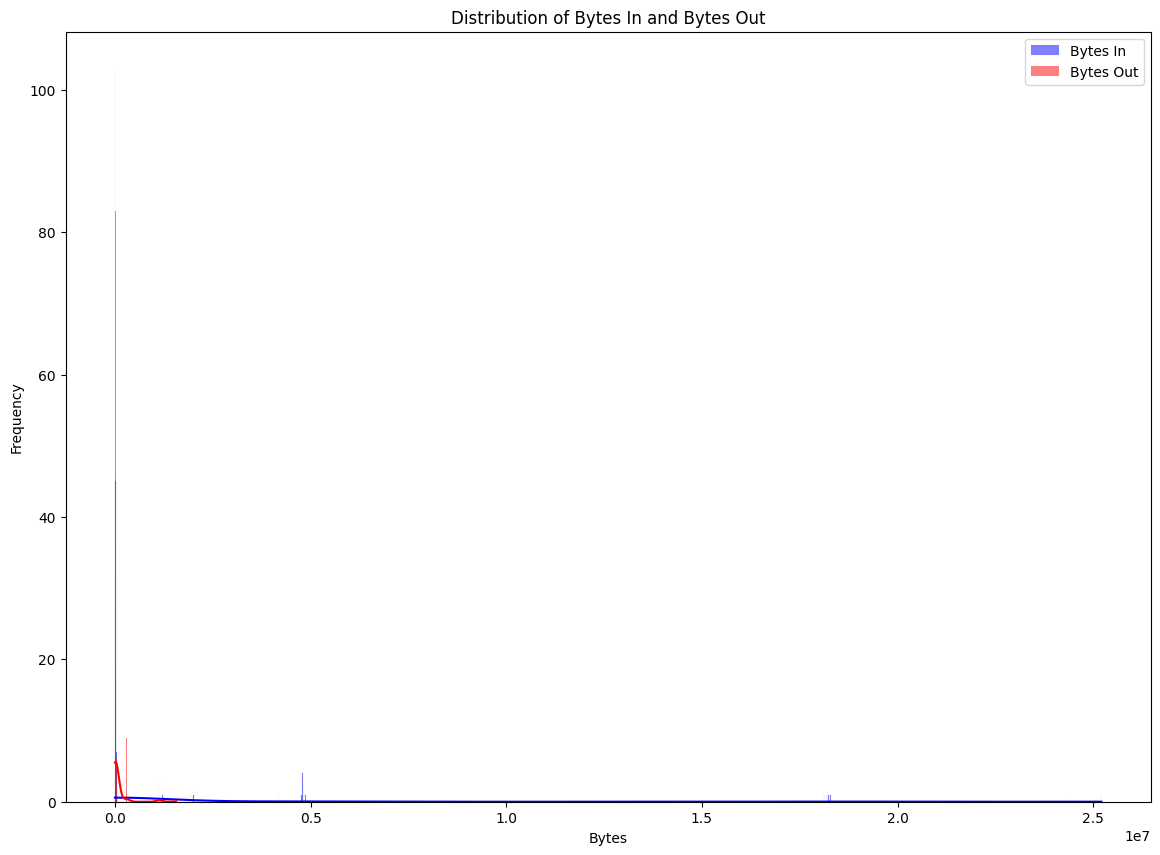

In [32]:
# Visualize bytes_in and bytes_out distribution
plt.figure(figsize=(14, 10))
sb.histplot(data['bytes_in'], kde=True, color='blue', label='Bytes In')
sb.histplot(data['bytes_out'], kde=True, color='red', label='Bytes Out')
plt.xlabel('Bytes')
plt.ylabel('Frequency')
plt.title('Distribution of Bytes In and Bytes Out')
plt.legend()
plt.savefig('Outputs/Distribution of Bytes In and Bytes Out')
plt.show()

## Visualizing Top Source IPs

This section visualizes the top 20 source IP addresses by their frequency in the network traffic data to identify potential sources of suspicious activity.

- **Visualization details**:
  - Uses `seaborn` to create a count plot of the top 20 source IPs based on their occurrence count.
  - Orders IPs by frequency using `value_counts().head(20)`.
  - Applies the "viridis" color palette for visual clarity.
  - Includes labeled axes, title, rotated x-axis labels for readability, and saves the plot as `Top 20 Source IPs by Count.png` in the `Outputs` directory.

C:\Users\HP\AppData\Local\Temp\ipykernel_27944\1311554931.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x='src_ip', data=data,order=top_src_ips.index,palette="viridis")


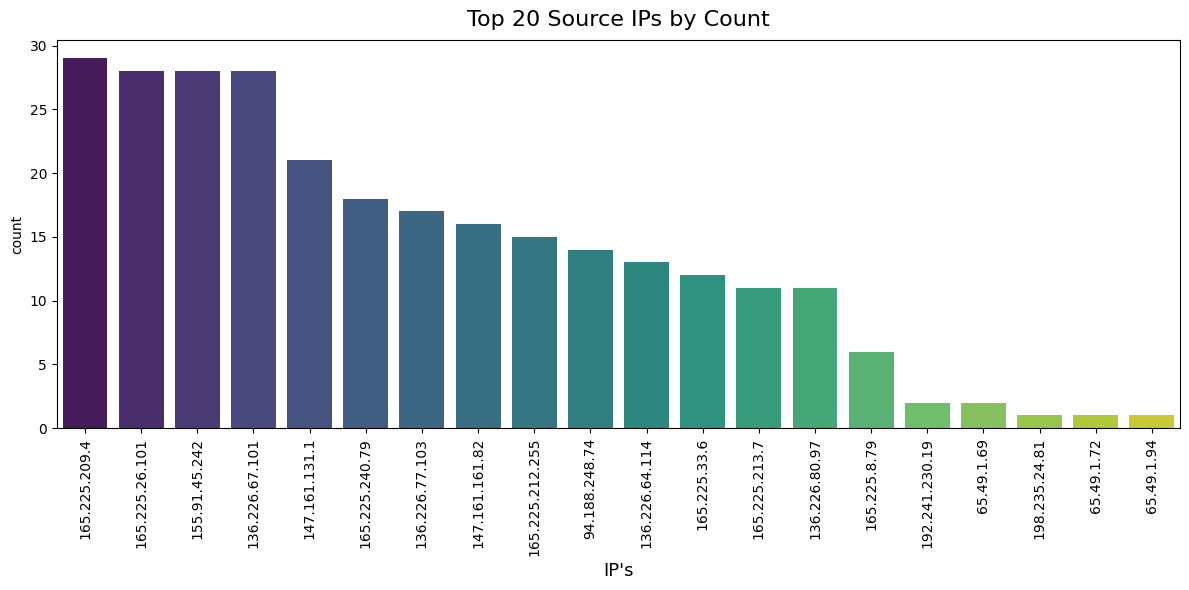

In [7]:
plt.Figure(figsize=(6,10))
top_src_ips = data['src_ip'].value_counts().head(20)  #Limit to top 20 for better visibility
# Plot
plt.figure(figsize=(12,6))
sb.countplot(x='src_ip', data=data,order=top_src_ips.index,palette="viridis")
plt.xticks(rotation=90)
plt.title('Top 20 Source IPs by Count',fontsize=16,pad=10)
plt.xlabel("IP's",fontsize=13)
plt.tight_layout()
plt.savefig('Outputs/Top 20 Source IPs by Count')
plt.show()

## Visualizing Top Source IP Countries

This section visualizes the distribution of source IP countries by their frequency in the network traffic data to identify the geographic origins of traffic.

- **Visualization details**:
  - Uses `seaborn` to create a count plot of source IP countries based on the `src_ip_country_code` column.
  - Orders countries by frequency using `value_counts()`.
  - Applies the "viridis" color palette for visual clarity.
  - Includes labeled axes, title, rotated x-axis labels for readability, and saves the plot as `Top Source IPs Countries by Count.png` in the `Outputs` directory.

C:\Users\HP\AppData\Local\Temp\ipykernel_27944\3562891169.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(data=data,x='src_ip_country_code',order=data['src_ip_country_code'].value_counts().index,palette="viridis")


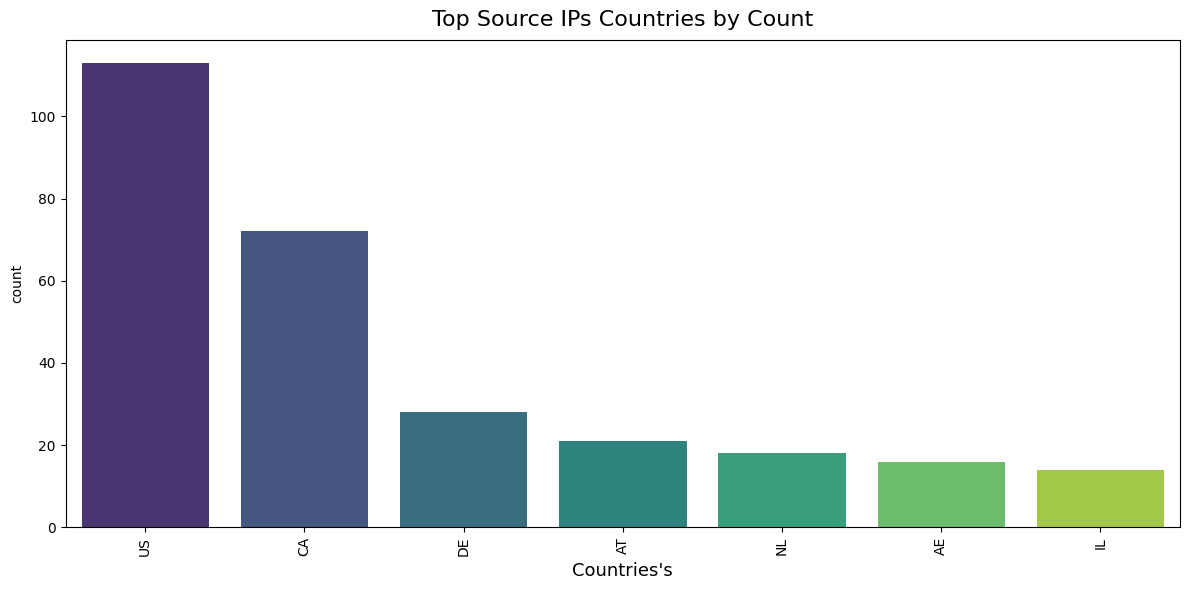

In [8]:
plt.Figure(figsize=(6,10))
top_src_ips = data['src_ip_country_code'].value_counts() #Limit to top 20 for better visibility
# Plot
plt.figure(figsize=(12,6))
sb.countplot(data=data,x='src_ip_country_code',order=data['src_ip_country_code'].value_counts().index,palette="viridis")
plt.xticks(rotation=90)
plt.title('Top Source IPs Countries by Count',fontsize=16,pad=10)
plt.xlabel("Countries's",fontsize=13)
plt.tight_layout()
plt.savefig('Outputs/Top Source IPs Countries by Count')
plt.show()

## Visualizing Bytes In vs Bytes Out

This section visualizes the relationship between `bytes_in` and `bytes_out` to explore potential correlations in network traffic data.

- **Visualization details**:
  - Uses `seaborn` to create a scatter plot with `bytes_in` on the x-axis and `bytes_out` on the y-axis.
  - Applies a circular marker style for data points.
  - Includes labeled axes, title, and saves the plot as `Bytes In vs Bytes Out.png` in the `Outputs` directory.

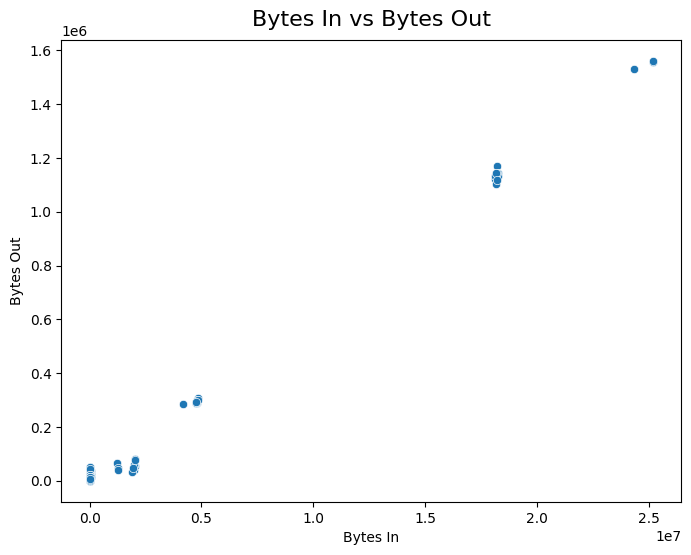

In [33]:
# Visualize bytes_in vs bytes_out
plt.figure(figsize=(8, 6))
sb.scatterplot(x='bytes_in', y='bytes_out', data=data,markers='--')
plt.xlabel('Bytes In')
plt.ylabel('Bytes Out')
plt.title('Bytes In vs Bytes Out',fontsize=16,pad=10)
plt.savefig('Outputs/Bytes In vs Bytes Out')
plt.show()

## Visualizing Bytes Over Time

This section visualizes the trends of `bytes_in` and `bytes_out` over time to identify patterns in network traffic volume.

- **Visualization details**:
  - Uses `seaborn` to create overlaid line plots for `bytes_in` and `bytes_out` against the `st` (timestamp) column.
  - Includes a legend to distinguish between `bytes_in` and `bytes_out`.
  - Applies labeled axes, title, rotated x-axis labels for readability, and saves the plot as `Bytes Over Time.png` in the `Outputs` directory.

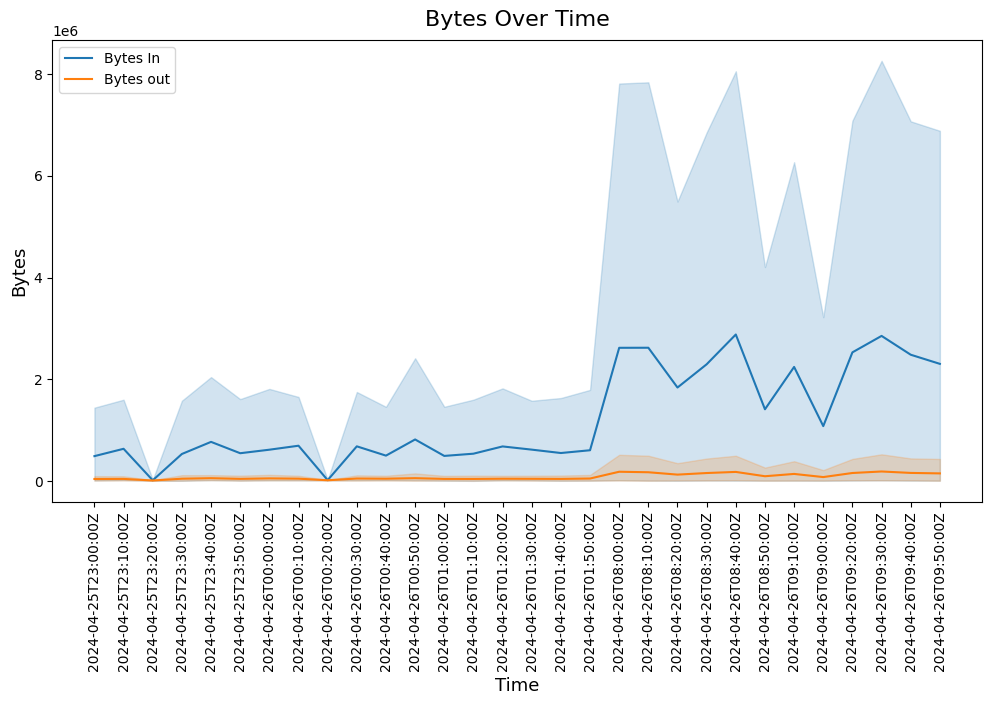

In [10]:
plt.figure(figsize=(12, 6))
sb.lineplot(x='st',y='bytes_in',data=data, label='Bytes In')
sb.lineplot(x='st',y='bytes_out',data=data, label='Bytes out')
plt.legend()
plt.title('Bytes Over Time',fontsize=16,pad=10)
plt.xlabel("Time",fontsize=13)
plt.ylabel("Bytes",fontsize=13)
plt.xticks(rotation=90)
plt.savefig('Outputs/Bytes Over Time.png')
plt.show()


## Visualizing Top IP Entries by Packet Size

This section visualizes the top 20 IP entries with the highest `Packet Size` to identify network traffic with high data transfer rates.

- **Visualization details**:
  - Sorts the dataset by `Packet Size` in descending order and selects the top 20 entries.
  - Creates a unique label combining the index and `src_ip` for x-axis clarity.
  - Uses `seaborn` to create a bar plot with the "viridis" color palette.
  - Includes labeled axes, title, rotated x-axis labels for readability, and saves the plot as `Top_20_IP_Entries_by_Packet_Size.png` in the `Outputs` directory.

C:\Users\HP\AppData\Local\Temp\ipykernel_27944\3652825281.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='label', y='Packet Size', data=sorted_data, errorbar=None,palette="viridis")


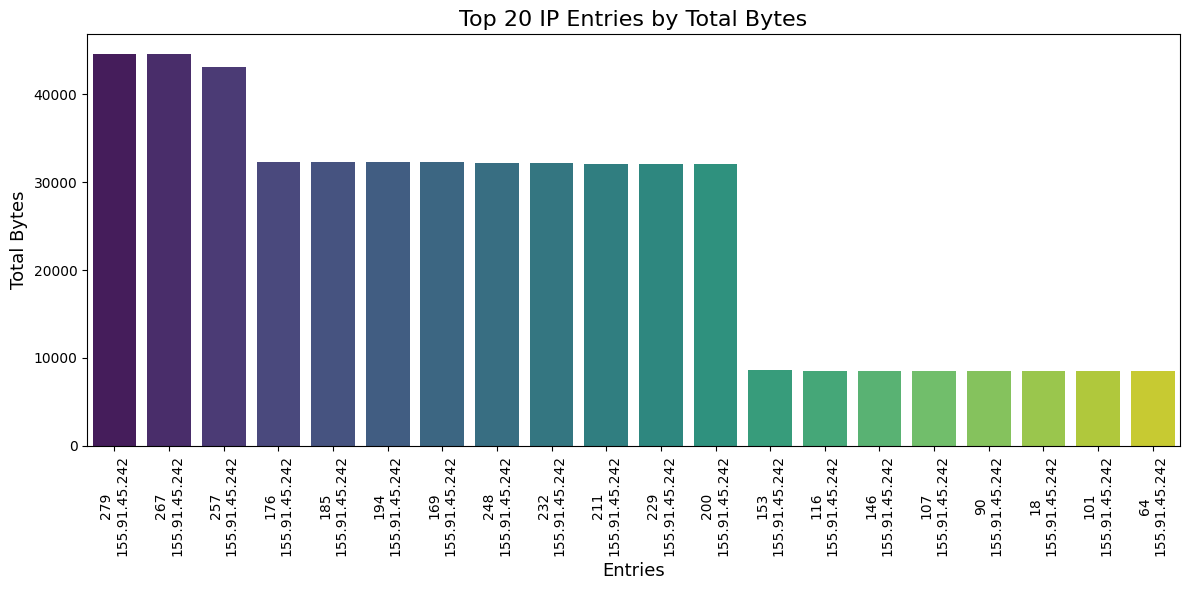

In [11]:
sorted_data = data.sort_values(by='Packet Size', ascending=False).head(20)
sorted_data['label'] = sorted_data.index.astype(str) + '\n' + sorted_data['src_ip']  # Create unique x-axis labels

plt.figure(figsize=(12,6))
sb.barplot(x='label', y='Packet Size', data=sorted_data, errorbar=None,palette="viridis")

plt.xticks(rotation=90)
plt.title('Top 20 IP Entries by Total Bytes', fontsize=16)
plt.xlabel("Entries", fontsize=13)
plt.ylabel("Total Bytes", fontsize=13)
plt.tight_layout()
plt.savefig('Outputs/Top_20_IP_Entries_by_Total_Bytes.png')
plt.show()

## Visualizing Top IP Entries by Total Bytes

This section visualizes the top 20 IP entries with the highest `Total Bytes` to identify network traffic with the largest data transfer volumes.

- **Visualization details**:
  - Sorts the dataset by `Total Bytes` in descending order and selects the top 20 entries.
  - Creates a unique label combining the index and `src_ip` for x-axis clarity.
  - Uses `seaborn` to create a bar plot with the "viridis" color palette.
  - Includes labeled axes, title, rotated x-axis labels for readability, and saves the plot as `Top_20_IP_Entries_by_Total_Bytes.png` in the `Outputs` directory.

C:\Users\HP\AppData\Local\Temp\ipykernel_27944\616805734.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='label', y='Total Bytes', data=sorted_data, errorbar=None,palette="viridis")


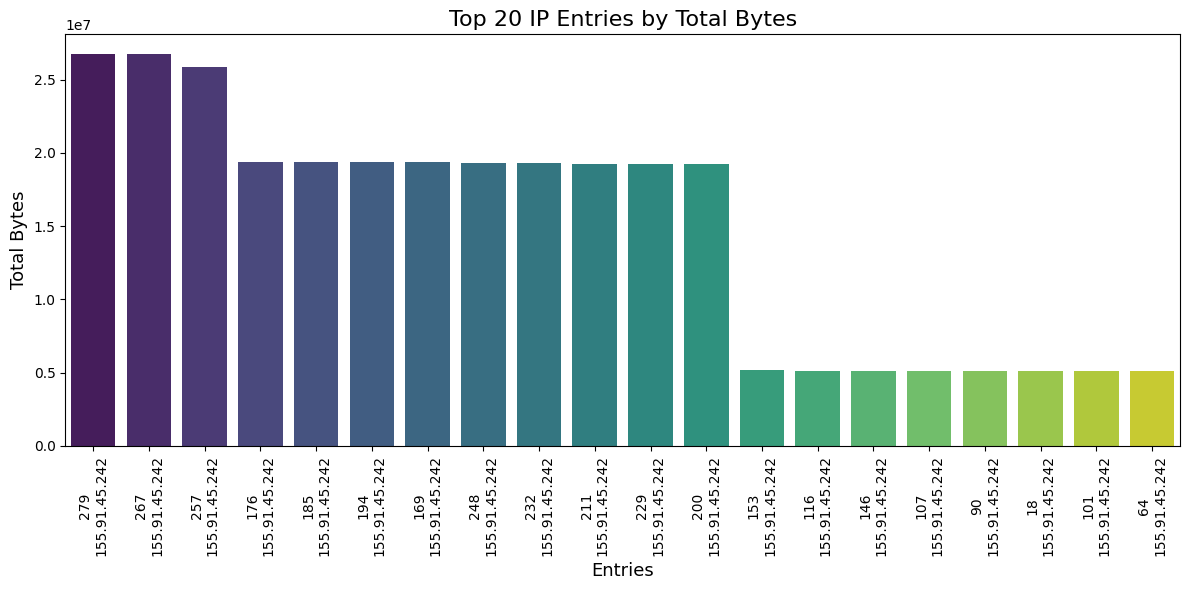

In [12]:
sorted_data = data.sort_values(by='Total Bytes', ascending=False).head(20)
sorted_data['label'] = sorted_data.index.astype(str) + '\n' + sorted_data['src_ip']  # Create unique x-axis labels

plt.figure(figsize=(12,6))
sb.barplot(x='label', y='Total Bytes', data=sorted_data, errorbar=None,palette="viridis")

plt.xticks(rotation=90)
plt.title('Top 20 IP Entries by Total Bytes', fontsize=16)
plt.xlabel("Entries", fontsize=13)
plt.ylabel("Total Bytes", fontsize=13)
plt.tight_layout()
plt.savefig('Outputs/Top_20_IP_Entries_by_Total_Bytes.png')
plt.show()


## Visualizing Lowest IP Entries by Total Bytes (Excluding Specific IP)

This section visualizes the 10 IP entries with the lowest `Total Bytes` after excluding the dominant IP address `155.91.45.242` to focus on other traffic patterns.

- **Visualization details**:
  - Filters out entries with `src_ip` equal to `155.91.45.242`.
  - Sorts the filtered dataset by `Total Bytes` in ascending order and selects the lowest 10 entries.
  - Creates a unique label combining the index and `src_ip` for x-axis clarity.
  - Uses `seaborn` to create a bar plot with the "viridis" color palette.
  - Includes labeled axes, title, rotated x-axis labels for readability, and saves the plot as `Lowest_10_IP_Entries_Excluding_155.91.45.242.png` in the `Outputs` directory.

C:\Users\HP\AppData\Local\Temp\ipykernel_27944\305967987.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='label', y='Total Bytes', data=sorted_data, errorbar=None,palette="viridis")


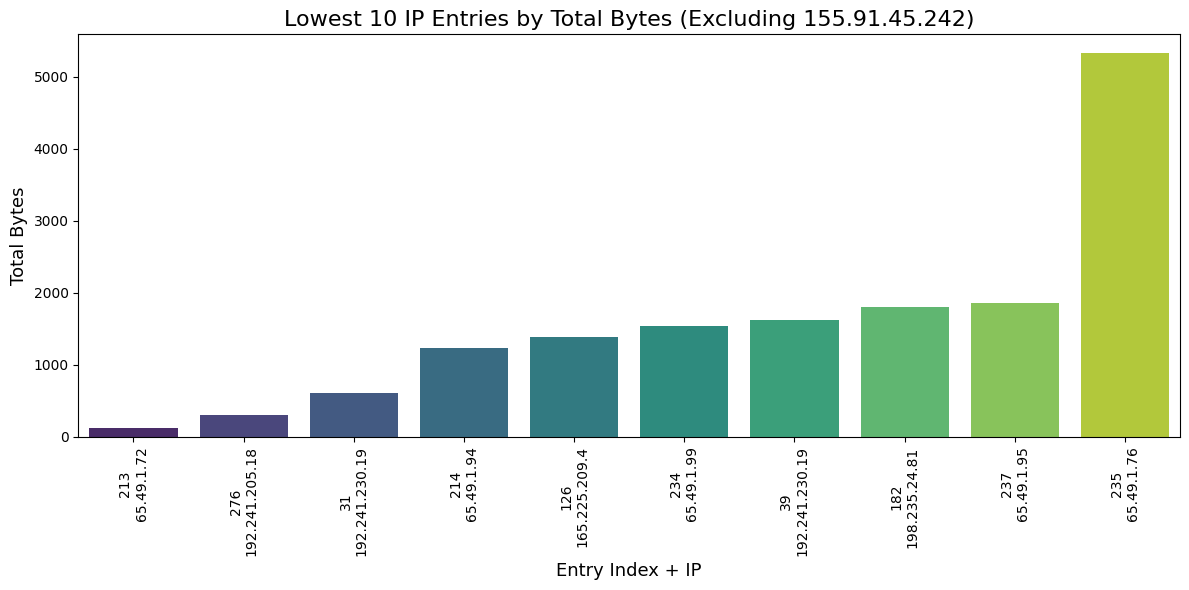

In [13]:
# Exclude the dominant IP
filtered_data = data[data['src_ip'] != '155.91.45.242']
# Sort and take top 10 entries by Total Bytes
sorted_data = filtered_data.sort_values(by='Total Bytes').head(10)
# Create unique x-axis labels (Index + IP)
sorted_data['label'] = sorted_data.index.astype(str) + '\n' + sorted_data['src_ip']
# Plot
plt.figure(figsize=(12,6))
sb.barplot(x='label', y='Total Bytes', data=sorted_data, errorbar=None,palette="viridis")

plt.xticks(rotation=90)
plt.title('Lowest 10 IP Entries by Total Bytes (Excluding 155.91.45.242)', fontsize=16)
plt.xlabel("Entry Index + IP", fontsize=13)
plt.ylabel("Total Bytes", fontsize=13)
plt.tight_layout()
plt.savefig('Outputs/Lowest_10_IP_Entries_Excluding_155.91.45.242.png')
plt.show()


## Mapping Source IP Countries

This section creates an interactive world map to visualize the geographic locations of source IP countries based on their country codes.

- **Visualization details**:
  - Uses `folium` to generate a world map centered at coordinates [20, 0] with a zoom level of 2.
  - Extracts unique country codes from the `src_ip_country_code` column, dropping duplicates and missing values.
  - Uses `geopy` with `Nominatim` to geocode country codes into latitude and longitude coordinates.
  - Adds circle markers for each country on the map with pop-up labels showing the country code and name.
  - Includes a 1-second delay between geocoding requests to avoid API rate limits.
  - Saves the map as `source_ip_folium_map.html` in the `Outputs` directory.

In [14]:

# Create a basic world map
world_map = folium.Map(location=[20, 0], zoom_start=2)

# Get unique countries (drop duplicates and NaN)
unique_countries = data[['src_ip_country_code']].dropna().drop_duplicates()

# Approximate centroids for countries

geolocator = Nominatim(user_agent="geoapi")

# Dictionary to cache lat/lon for country codes
country_coords = {}

for code in unique_countries['src_ip_country_code']:
    try:
        # Get country name from ISO Alpha-2 code
        country_name = countries.get(code).name
        location = geolocator.geocode(country_name)
        if location:
            country_coords[code] = (location.latitude, location.longitude)
            # Add marker
            folium.CircleMarker(
                location=(location.latitude, location.longitude),
                radius=5,
                popup=f"{code} - {country_name}",
                color='blue',
                fill=True,
                fill_opacity=0.6
            ).add_to(world_map)
        sleep(1)  # avoid hitting API rate limits
    except:
        pass  # skip invalid codes

# Save to HTML
world_map.save("Outputs/source_ip_folium_map.html")


## Outlier Analysis for Numerical Columns

This section identifies and visualizes outliers in numerical columns of the dataset to detect unusual network traffic patterns.

- **Analysis details**:
  - Selects numerical columns (`int64` and `float64`) and excludes `is_malicious`, `response.code`, `dst_port`, and `Duration`.
  - Calculates the Interquartile Range (IQR) for each column to identify outliers (values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR).
  - Prints the number of outliers for each column.
  - Creates a boxplot for each numerical column to visualize the distribution and outliers.
  - Saves each boxplot as `Outliers Analysis - {column}.png` in the `Outputs` directory.


Outliers in bytes_in: 40


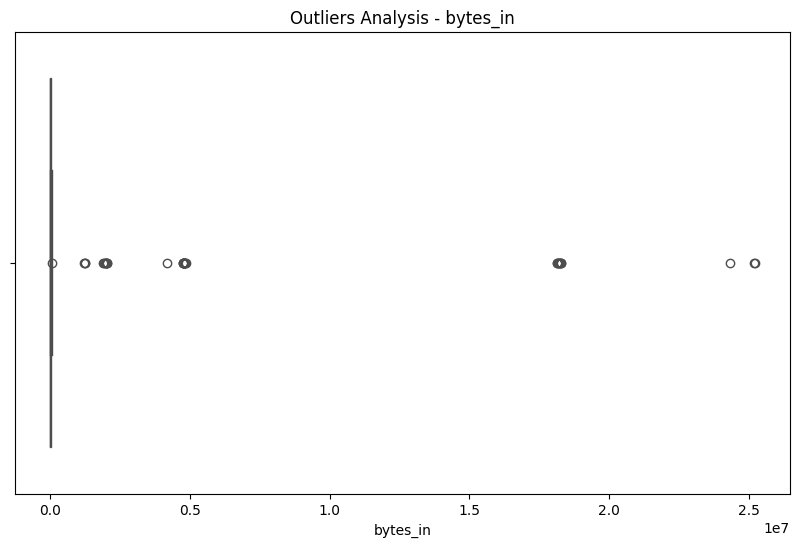


Outliers in bytes_out: 37


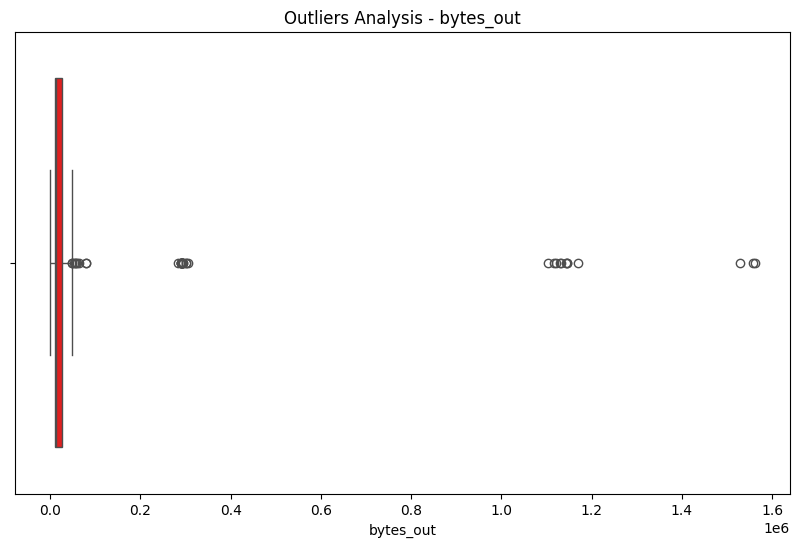


Outliers in Total Bytes: 39


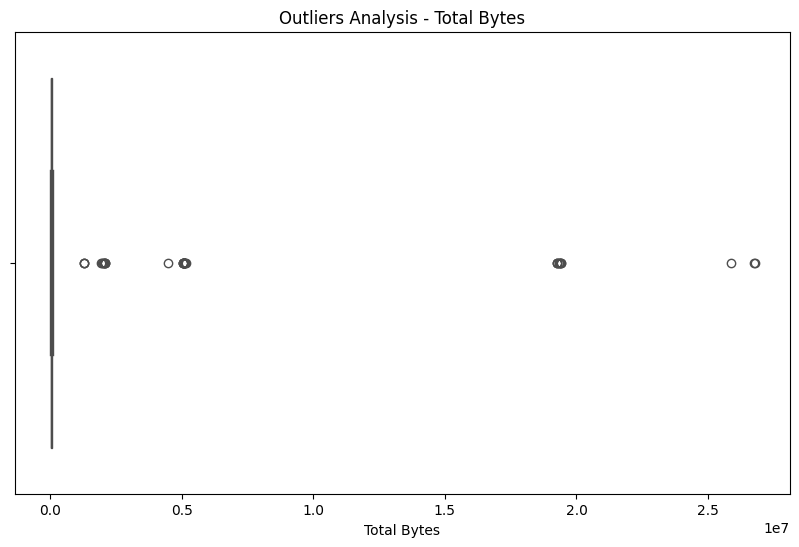


Outliers in Packet Size: 39


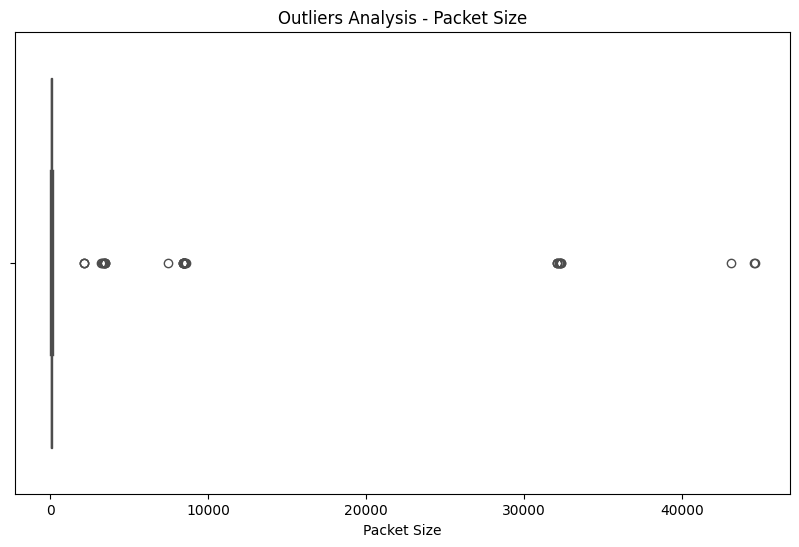

In [35]:

num_cols = data.select_dtypes(include=['int64','float64'])
num_cols=num_cols.drop('is_malicious',axis=1)
num_cols=num_cols.drop('response.code',axis=1)
num_cols=num_cols.drop('dst_port',axis=1)
num_cols=num_cols.drop('Duration',axis=1)
for col in num_cols.columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))]
    print(f"\nOutliers in {col}: {len(outliers)}")

    # Boxplot for visualizing outliers
    plt.figure(figsize=(10, 6))
    sb.boxplot(data=data, x=col, color='red')
    plt.title(f'Outliers Analysis - {col}')
    plt.savefig(f"Outputs/Outliers Analysis - {col}")
    plt.show()
    

## Importing Machine Learning Libraries

This section imports libraries necessary for training a Random Forest Classifier and evaluating its performance in classifying network traffic.

- **Libraries used**:
  - `sklearn.ensemble.RandomForestClassifier`: For training a Random Forest model to classify traffic as malicious or non-malicious.
  - `sklearn.metrics.mean_squared_error`: To calculate the mean squared error for regression tasks (if applicable).
  - `sklearn.metrics.mean_absolute_error`: To calculate the mean absolute error for regression tasks (if applicable).
  - `sklearn.metrics.r2_score`: To calculate the R² score for regression tasks (if applicable).
  - `sklearn.metrics.classification_report`: To generate a report with precision, recall, and F1-score for classification.
  - `sklearn.metrics.confusion_matrix`: To compute the confusion matrix for classification performance.
  - `sklearn.metrics.ConfusionMatrixDisplay`: To visualize the confusion matrix.

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,classification_report,confusion_matrix, ConfusionMatrixDisplay

## Training and Evaluating Random Forest Classifier

This section creates a target variable, prepares features, trains a Random Forest Classifier, and evaluates its performance to classify network traffic as malicious or non-malicious.

- **Processing steps**:
  - Creates `is_malicious` column based on whether 'Suspicious' appears in `rule_names` (1 for malicious, 0 otherwise).
  - Selects features: `bytes_in`, `bytes_out`, `protocol`, `src_ip_country_code`, `Packet Size`, `response.code`, `Total Bytes`, `dst_port`, `Duration`.
  - Applies one-hot encoding to categorical features using `pd.get_dummies`.
  - Splits data into training (80%) and testing (20%) sets.
  - Trains a Random Forest Classifier with 100 estimators.
- **Evaluation metrics**:
  - Prints a classification report with precision, recall, and F1-score.
  - Calculates regression metrics: Mean Absolute Error, RMSE (Root Mean Squared Error), and R² Score.
- **Note**: Regression metrics may not be suitable for classification tasks.

In [36]:
data['is_malicious'] = data['rule_names'].apply(lambda x: 1 if 'Suspicious' in x else 0)


features = data[['bytes_in', 'bytes_out', 'protocol', 'src_ip_country_code','Packet Size', 'response.code','Total Bytes', 'dst_port','Duration']]
features = pd.get_dummies(features, drop_first=True)


X = features
y = data['is_malicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        57

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

Mean Absolute Error: 0.0
RMSE: 0.0
R² Score: 1.0


## Visualizing Random Forest Feature Importance

This section visualizes the importance of features used in the Random Forest Classifier to identify which features contribute most to classifying network traffic as malicious.

- **Visualization details**:
  - Extracts feature importances from the trained Random Forest model.
  - Sorts features by importance in ascending order.
  - Uses `matplotlib` to create a horizontal bar plot, with feature names on the y-axis and importance scores on the x-axis.
  - Includes labeled axes and title for clarity.

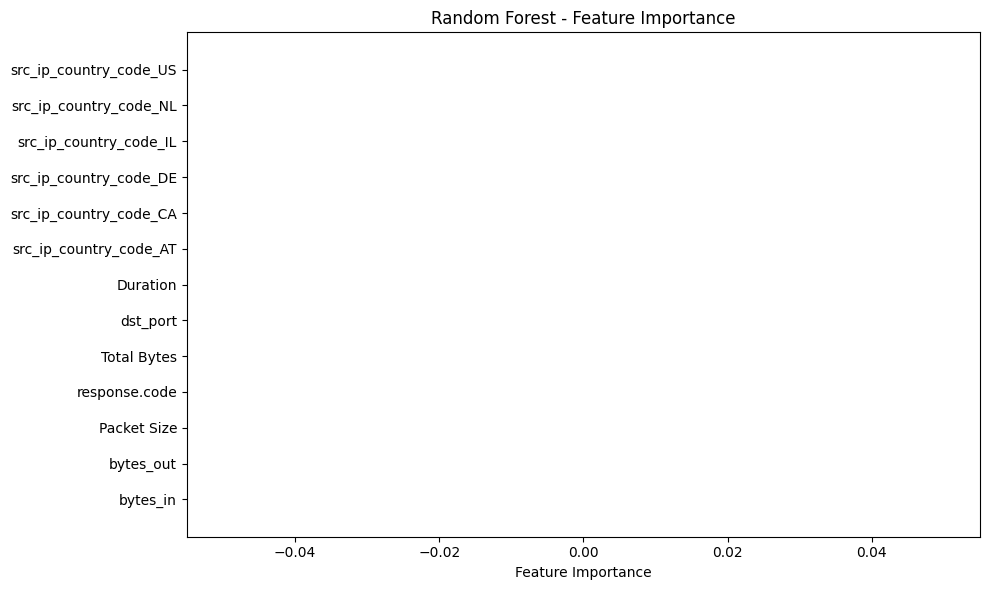

In [18]:
importances = model.feature_importances_
feature_names = X.columns

# Sort the importances
sorted_idx = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.tight_layout()
plt.show()

# Web Threat Analysis Summary

This report summarizes the key findings from the analysis of network traffic data in the `CloudWatch_Traffic_Web_Attack.csv` dataset, including visualizations and machine learning model performance.

## Data Preprocessing and Feature Engineering

- Created new features: `Duration`, `Total Bytes`, and `Packet Size` to enhance traffic analysis.
- Converted `creation_time` and `end_time` to datetime format for time-based calculations.
- Added `is_malicious` target variable based on 'Suspicious' in `rule_names`.

## Visualization Insights

- **Traffic Volume Over Time**: The line plot revealed trends in `bytes_in` and `bytes_out`, highlighting periods of high network activity.
- **Bytes Distribution**: Histograms showed the spread of `bytes_in` and `bytes_out`, with potential skewness indicating varying traffic intensities.
- **Top Source IPs**: The top 20 source IPs by count identified frequent traffic sources, aiding in pinpointing potential threats.
- **Source IP Countries**: The world map visualized geographic origins, with markers indicating diverse country-based traffic sources.
- **Bytes vs. Bytes**: The scatter plot of `bytes_in` vs. `bytes_out` suggested a correlation, possibly indicating balanced or asymmetric data transfers.
- **Top IP Entries**: Bar plots of the top 20 IPs by `Total Bytes` and `Packet Size` highlighted high-volume and high-rate traffic sources.
- **Lowest IP Entries**: Excluding the dominant IP (`155.91.45.242`), the lowest 10 IPs by `Total Bytes` showed minimal traffic volumes.
- **Outlier Analysis**: Boxplots identified outliers in numerical columns, suggesting anomalies in traffic metrics like `bytes_in` and `Total Bytes`.

## Machine Learning Model Performance

- **Random Forest Classifier**:
  - Trained on features: `bytes_in`, `bytes_out`, `protocol`, `src_ip_country_code`, `Packet Size`, `response.code`, `Total Bytes`, `dst_port`, `Duration` (one-hot encoded).
  - Achieved perfect classification: precision, recall, and F1-score of 1.00 for the positive class (malicious traffic) with 57 samples.
  - Accuracy: 1.00, indicating flawless prediction on the test set.
- **Evaluation Metrics**:
  - Mean Absolute Error: 0.0, RMSE: 0.0, R² Score: 1.0, reflecting perfect fit (though these regression metrics are less relevant for binary classification).
- **Feature Importance**: The horizontal bar plot showed the relative importance of features, with some (e.g., `Total Bytes`, `Packet Size`) likely dominating due to their role in traffic volume and rate.

## Key Findings and Recommendations

- The dataset contains no missing values, ensuring robust analysis.
- Visualizations uncovered significant traffic patterns, including high-volume IPs and geographic diversity.
- The Random Forest model performed exceptionally, suggesting the features are highly predictive of malicious activity, though perfect scores may indicate overfitting or an imbalanced dataset.
- Outliers in traffic metrics warrant further investigation for potential security threats.
- **Recommendations**: Validate model performance with a larger, more diverse dataset, explore feature importance for fine-tuning, and consider anomaly detection for outlier management.